In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# Read all data files of one category.
import os

trajectories_per_category = {}
categories = ['alive', 'fibro', 'plastic']
downsample_steps = [2, 5, 5]
for category, downsample_step in zip(categories, downsample_steps):
    data_dir = 'data/JulianTrajs/' + category
    trajectories_per_category[category] = []  # dimensions: trajectory index -> time step -> coordinate (x, y, z)
    filenames = os.listdir(data_dir)    
    for filename in filenames:
        trajectory = np.genfromtxt(os.path.join(data_dir, filename))
        for start in range(downsample_step):
            end = -(downsample_step - start)
            sliced_trajectory = trajectory[start:end:downsample_step]
            trajectories_per_category[category].append(sliced_trajectory)
    trajectories_per_category[category] = np.array(trajectories_per_category[category])
    print "Category {}: Found {} files, created {} trajectories".format(category, len(filenames), len(trajectories_per_category[category]))

Category alive: Found 65 files, created 130 trajectories
Category fibro: Found 69 files, created 345 trajectories
Category plastic: Found 177 files, created 885 trajectories


In [3]:
# Convert to velocities (um / min).
for category in trajectories_per_category:
    trajectories_per_category[category] = np.diff(trajectories_per_category[category], axis=1) / 5.

In [4]:
# Normalize trajectories to [-1, 1] for the LSTM network (it outputs values between -1 and 1 by default)
# TODO: Do not use min/max values here but fixed value to generalize to other datasets.
min_value = np.min([np.min(traj) for traj in trajectories_per_category.values()])
max_value = np.max([np.max(traj) for traj in trajectories_per_category.values()])
for category in trajectories_per_category:
    trajectories_per_category[category] = np.interp(trajectories_per_category[category], [min_value, max_value], [-1., 1.])

In [5]:
# TODO: Split the original trajectories into training/test so we can use the same split for mini trajectories of different sizes.
# TODO: Use seed when shuffling so we always get the same training/test split.

In [6]:
def shuffle_together(*args):
    rng_state = np.random.get_state()
    for arg in args:
        np.random.shuffle(arg)
        np.random.set_state(rng_state)

In [7]:
def split(arr, fraction):
    index_to_split = int(np.rint(fraction * len(arr)))
    return arr[:index_to_split], arr[index_to_split:]

In [8]:
len_mini_trajectories = 10
# TODO: Maybe train on mini trajectories of different sizes, so the nn learns to generalize on arbitrarily long trajectories.
step = 5

mini_trajectories_per_category = {}
category_to_target = {'alive': 0, 'fibro': 1, 'plastic': 2}
target_to_category = {0: 'alive', 1: 'fibro', 2: 'plastic'}

for category in trajectories_per_category:
    
    mini_trajectories_per_category[category] = []
    
    for trajectory in trajectories_per_category[category]:
        for i in range(0, len(trajectory) - len_mini_trajectories, step):
            mini_trajectories_per_category[category].append(trajectory[i:i+len_mini_trajectories])# - trajectory[i])  # Set start of mini trajectory to origin.
            
    print 'Created {} mini trajectories for {}'.format(len(mini_trajectories_per_category[category]), category)
    
# Take the same number of trajectories per category so we train equal on all categories.
num_mini_trajectories_per_category = np.min([len(arr) for arr in mini_trajectories_per_category.values()])

mini_trajectories = []
classes = []
for category, mini_traj in mini_trajectories_per_category.items():
    np.random.shuffle(mini_traj)
    mini_trajectories.extend(mini_traj[:num_mini_trajectories_per_category])
    classes.extend([category_to_target[category]] * num_mini_trajectories_per_category)

mini_trajectories = np.array(mini_trajectories)
classes = np.array(classes)
from keras.utils import np_utils
targets = np_utils.to_categorical(classes, 3)

# TODO: Take different mini trajectories for each epoch to learn on all data, not just a subset.
# Or just take the small dataset multiple times for the mini trajectories.

shuffle_together(mini_trajectories, classes, targets)

print 'Taking {} mini trajectories for each category --> Total: {}'.format(num_mini_trajectories_per_category, len(mini_trajectories))   

Created 13110 mini trajectories for fibro
Created 7280 mini trajectories for alive
Created 33630 mini trajectories for plastic
Taking 7280 mini trajectories for each category --> Total: 21840


In [9]:
# TODO: Split validation dataset here and pass it to fit function via validation_data parameter.
test_mini_trajectories, training_mini_trajectories = split(mini_trajectories, 0.1)
test_classes, training_classes = split(classes, 0.1)
test_targets, training_targets = split(targets, 0.1)

In [10]:
# Set up the network.
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM

model = Sequential()

# TODO: Train with different number of LSTM layers and LSTM layer sizes and compare accuracy.
model.add(LSTM(input_dim=3, output_dim=10, return_sequences=True))
#model.add(Dropout(0.05))
#model.add(LSTM(output_dim=10, return_sequences=True))
model.add(LSTM(output_dim=10, return_sequences=False))
#model.add(Dropout(0.05))
model.add(Dense(output_dim=3))
model.add(Activation('softmax'))

# TODO: Add Dropout and more LSTM layers. 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

Using Theano backend.
D:\Python\27_32bit\lib\site-packages\theano\tensor\signal\downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [11]:
# Callback to evaluate accuracy for each class during training. 
from keras.callbacks import Callback
class ClassHistory(Callback):
    def on_train_begin(self, logs={}):
        self.class_acc = [[], [], []]
        
    def on_epoch_end(self, epoch, logs={}):
        training_predicted = self.model.predict_classes(training_mini_trajectories, verbose=0)
        for which_class in [0, 1, 2]:
            training_acc = 1. * np.sum(training_predicted[training_classes == which_class] == which_class) / len(training_predicted[training_classes == which_class])
            self.class_acc[which_class].append(training_acc)
            
classHistory = ClassHistory()

In [ ]:
# TODO: Train with mini trajectories of different lengths and compare the network performance. 
# Make plot with accuracy over epochs for different mini trajectories length.
# According to the RBM thesis, the data should be correlated for 3 to 7 (corrected) time steps. 
# See details for each category in the thesis - can we replicate this with the NN?
# TODO: Train with different lengths at the same time. 

# TODO: Play around with parameters of rmsprop.
# TODO: Use sample_weight or class_weight parameter and see if it can fix unequally distributed data. 
hist = model.fit(training_mini_trajectories, training_targets, 
                 batch_size=15, nb_epoch=50, 
                 verbose=1, show_accuracy=True, validation_split=0.05, callbacks=[classHistory])

Train on 18673 samples, validate on 983 samples
Epoch 1/50
18673/18673 [==============================] - 32s - loss: 0.2500 - acc: 0.9005 - val_loss: 0.2479 - val_acc: 0.9054
Epoch 2/50
18673/18673 [==============================] - 32s - loss: 0.2495 - acc: 0.9010 - val_loss: 0.2431 - val_acc: 0.9125
Epoch 3/50
18673/18673 [==============================] - 33s - loss: 0.2488 - acc: 0.9013 - val_loss: 0.2715 - val_acc: 0.8942
Epoch 4/50
18673/18673 [==============================] - 27s - loss: 0.2470 - acc: 0.9036 - val_loss: 0.2616 - val_acc: 0.8840
Epoch 5/50
18673/18673 [==============================] - 28s - loss: 0.2466 - acc: 0.9035 - val_loss: 0.2480 - val_acc: 0.9074
Epoch 6/50
18673/18673 [==============================] - 28s - loss: 0.2448 - acc: 0.9040 - val_loss: 0.2625 - val_acc: 0.8911
Epoch 7/50
18673/18673 [==============================] - 28s - loss: 0.2430 - acc: 0.9038 - val_loss: 0.2342 - val_acc: 0.9095
Epoch 8/50
18673/18673 [==============================] 

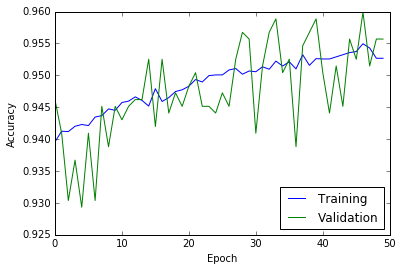

In [30]:
# TODO: Use validation or test data for this plot?
# TODO: Make epochs start at 1 or record accuracy before training.
plt.plot(hist.history['acc'], label='Training')
plt.plot(hist.history['val_acc'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

#plt.xlim(60, 100)
#plt.ylim(0.9, 1)

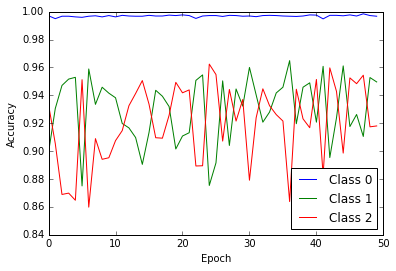

In [31]:
# TODO: Maybe try setting the weight for class 0 lower so the other classes get trained as well.
# TODO: Make this with training dataset.
for i, class_acc in enumerate(classHistory.class_acc):
    plt.plot(class_acc, '-', label="Class {}".format(i))
    
#plt.ylim(0, 1)
#plt.xlim(50, 70)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Class 0: 0.000
Class 1: 0.995
Class 2: 0.005
Is Class 1


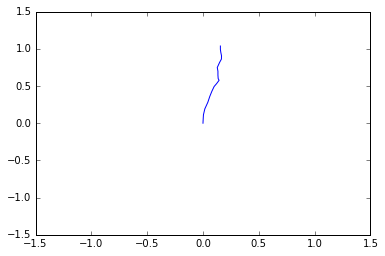

In [32]:
# Test on a random mini trajectory from the test dataset.
i = np.random.randint(len(test_mini_trajectories))
# TODO: Check if this is correct; most trajectories seem to go to the top right.
reconstructed_trajectory = np.cumsum(test_mini_trajectories[i], axis=0) - test_mini_trajectories[i, 0]
plt.plot(reconstructed_trajectory[:, 0], reconstructed_trajectory[:, 1])
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

probabilities, = model.predict(test_mini_trajectories[i:i+1])

for cat, prob in enumerate(probabilities):    
    print 'Class {}: {:.3f}'.format(cat, prob)    
        
print 'Is Class', test_classes[i]

In [ ]:
def evaluate(data, classes):
    predicted = model.predict_classes(data, verbose=0)
    acc = 1. * np.sum(predicted == classes) / len(predicted)
    return acc

In [ ]:
# Evaluate accuracy for each class. 
# TODO: Compare this to human performance.

# TODO: What does batch_size do in predict? Esp, is the state of the RNN preserved or reset during one batch?
# TODO: Maybe use evaluate together with show_accuracy for some of those things here.
training_predicted = model.predict_classes(training_mini_trajectories, verbose=0)
test_predicted = model.predict_classes(test_mini_trajectories, verbose=0)

training_acc = 1. * np.sum(training_predicted == training_classes) / len(training_predicted)
test_acc = 1. * np.sum(test_predicted == test_classes) / len(test_predicted)
print 'Overall accuracy:               Training: {:.3f}, Test: {:.3f}'.format(training_acc, test_acc)

for which_class in [0, 1, 2]:
    training_acc = 1. * np.sum(training_predicted[training_classes == which_class] == which_class) / len(training_predicted[training_classes == which_class])
    test_acc = 1. * np.sum(test_predicted[test_classes == which_class] == which_class) / len(test_predicted[test_classes == which_class])
    print 'Accuracy for class {} ({:^7}): Training: {:.3f}, Test: {:.3f}'.format(which_class, target_to_category[which_class], training_acc, test_acc)

In [ ]:
# TODO: Use only x and y coordinates for classification and compare to accuracy of using x/y/z data.
# TODO: Predict trajectory of one specific class. 

In [ ]:
# Evaluate accuracy for trajectories of different lengths (ie with different numbers of time steps).
# TODO: Does keras reset the state after each prediction?
# TODO: Make this work for all classes.
mini_trajectories_per_length = {}
for length in range(2, 30):
    mini_trajectories_per_length[length] = []
    for trajectory in trajectories_per_category['plastic']:  # TODO: Do this for all categories/for test dataset.
        for i in range(0, len(trajectory) - length, 5):
            mini_trajectories_per_length[length].append(trajectory[i:i+length])  # Set start of mini trajectory to origin.
    mini_trajectories_per_length[length] = np.array(mini_trajectories_per_length[length])

In [ ]:
acc = []
for length, traj in mini_trajectories_per_length.items():
    a = evaluate(traj, 2)
    print 'Accuracy for length {}: {:.3f}'.format(length, a)
    acc.append(a)    

In [ ]:
plt.plot(mini_trajectories_per_length.keys(), acc, 'o-')
plt.xlabel('Trajectory Length')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

In [ ]:
# TODO: Make plot that shows how often which class is predicted for different trajectory lengths
# (it seems that the network always predicts class 2 for small trajectories)

In [ ]:
# Parameters for optimzation:
# - mini trajectory length
# - mini trajectory step
# - output_dim
# - number of LSTM layers
# - rmsprop parameters (LOOK THESE UP)
# - batch_size
# - (maybe) class_weight
# - activation/internal parameters of LSTM
# - GRU etc.

# TODO before optimization:
# - check out class_weight
# - train with different lengths in the same dataset
# - x/y vs x/y/z
# - get training/validation/test split right (numbers + replicability)
# - use all data for learning not just subset (<-> class_weight)
# - infrastructure code to run experiments and save data (maybe also for classes/lengths), plots, models (architecture + weights)

In [ ]:
# Save model to file.
open('model/my_model_architecture.json', 'w').write(model.to_json())
model.save_weights('model/my_model_weights.h5')

In [ ]:
# Load model from file.
from keras.models import model_from_json
model = model_from_json(open('model/my_model_architecture.json').read())
model.load_weights('model/my_model_weights.h5')